In [1]:
import numpy as np
import pickle
from degree_days import  dd
from regional_average_contribution import  contribution
import pandas as pd
out_overall = pickle.load(open('../data/input/all_regions.pkl','r'))

import sys
import os

train_region, test_region, test_home, appliance, transform, K = "Austin","SanDiego", 203, "hvac","None",3
test_home = int(test_home)
K = int(K)

train_df = out_overall[train_region]
test_df = out_overall[test_region]

train_dd = pd.DataFrame(dd[train_region])
test_dd = pd.DataFrame(dd[test_region])

median_aggregate = {}
for region in [train_region, test_region]:
    median_aggregate[region] = {}
    for month in range(1, 13):
        median_aggregate[region][month] = out_overall[region]['aggregate_'+str(month)].median()

median_aggregate_df = pd.DataFrame(median_aggregate)


from itertools import combinations

start_month, end_month = 1,12
agg_features = np.hstack([['aggregate_'+str(month) for month in range(start_month, end_month+1)],
                         'ratio_min_max','difference_ratio_min_max','p_25','p_50','p_75','skew','kurtosis'])
md_features = ['area','house_num_rooms']
features = {'md_agg':np.hstack([
            agg_features,
            md_features
            ]).tolist()}

f_all = features['md_agg']

# Find not null set of common features
def find_com_features_train(df, home_1, home_2, featureset_max):
    f_1 = df.ix[home_1][featureset_max].dropna()
    f_2 = df.ix[home_2][featureset_max].dropna()
    com_f =  np.intersect1d(f_1.index, f_2.index)
    return com_f


def find_distance_train_test_quick(df_train, home_1, home_2, df_test, home_test, featureset_train, featureset_max):
    f_test = df_test.ix[home_test][featureset_max].dropna()
    com_f =  np.intersect1d(f_test.index, featureset_train)
    if len(com_f):
        is_common = True
    else:
        is_common = False
        return is_common, None

    if len(com_f):
        a = (df_train.ix[home_1][com_f]- df_test.ix[home_test][com_f]).abs().sum().sum()
        b = (df_train.ix[home_2][com_f]- df_test.ix[home_test][com_f]).abs().sum().sum()
        
        if a<=b:
            order = [home_1, home_2]
        else:
            order = [home_2, home_1]
        return is_common, {'order':order,
                    'num_f':len(com_f),
                    'dist_a':a,
                    'dist_b':b,
                          'f':com_f}


def find_distance_train_test(df_train, home_1, home_2, df_test, home_test, featureset_train, featureset_max):
    f_test = df_test.ix[home_test][featureset_max].dropna()
    com_f =  np.intersect1d(f_test.index, featureset_train)
    if len(com_f):
        is_common = True
    else:
        is_common = False
        return is_common, None

    if len(com_f):
        a = np.linalg.norm(df_train.ix[home_1][com_f]- df_test.ix[home_test][com_f])
        b = np.linalg.norm(df_train.ix[home_2][com_f]- df_test.ix[home_test][com_f])
        if a<=b:
            order = [home_1, home_2]
        else:
            order = [home_2, home_1]
        return is_common, {'order':order,
                    'num_f':len(com_f),
                    'dist_a':a,
                    'dist_b':b,
                          'f':com_f}

import pandas as pd

def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

def normalise(df):
    new_df = df.copy()
    max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
    min_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].min().min()
    new_df[["aggregate_%d" % i for i in range(1, 13)]] = scale_0_1(df[["aggregate_%d" % i for i in range(1, 13)]], min_aggregate, max_aggregate)
    for col in ['area','num_occupants','house_num_rooms','ratio_min_max',
                'skew','kurtosis','variance','difference_ratio_min_max','p_25',
               'p_50','p_75']:
        new_df[col] = scale_0_1(df[col])
    return new_df

if transform in ["None","None-percentage"]:
    pass
elif transform in ["DD","DD-percentage"]:
    train_df_copy = train_df.copy()
    for month in range(1, 13):
        # index on 0, 11
        train_dd_month = train_dd.ix[month-1]['Total']
        test_dd_month = test_dd.ix[month-1]['Total']
        train_df['hvac_%d' % month] = train_df_copy['hvac_%d' % month] * test_dd_month*1. / train_dd_month

        #New aggregate will be removing old HVAC and adding new HVAC!
        train_df['aggregate_%d' %month] = train_df_copy['aggregate_%d' %month] - train_df_copy['hvac_%d' % month] + train_df['hvac_%d' % month]
elif transform in ["median-aggregate","median-aggregate-percentage"]:
    train_df_copy = train_df.copy()
    for month in range(1,13):
        median_month = median_aggregate_df.ix[month]
        cols_to_transform = [x for x in train_df.columns if "_"+str(month) in x]
        train_df[cols_to_transform] = train_df_copy[cols_to_transform] * median_month[test_region] / median_month[train_region]

elif transform in ["regional","regional-percentage"]:
    train_df_copy = train_df.copy()
    for month in range(1, 13):

        # index on 0, 11
        if month in range(4,11):
            mode='Cooling'
        else:
            mode='Heating'

        train_dd_month = contribution[train_region][mode]['hvac']
        test_dd_month = contribution[test_region][mode]['hvac']

        train_df['hvac_%d' % month] = train_df_copy['hvac_%d' % month] * test_dd_month*1. / train_dd_month

        #New aggregate will be removing old HVAC and adding new HVAC!
        train_df['aggregate_%d' %month] = train_df_copy['aggregate_%d' %month] - train_df_copy['hvac_%d' % month] + train_df['hvac_%d' % month]



elif transform=="DD-fridge":
    train_df_copy = train_df.copy()
    fridge_model = pickle.load(open('../data/input/SanDiego_fridge_dd_coef.pkl','r'))
    for month in range(1, 13):
        # index on 0, 11

        train_cdd_month = train_dd.ix[month-1]['Cooling']
        test_cdd_month = test_dd.ix[month-1]['Cooling']
        for fridge_home, fridge_home_model in fridge_model.iteritems():
            train_df.loc[fridge_home,'fridge_%d' % month] = fridge_home_model['baseline']+fridge_home_model['cdd']*test_cdd_month
            train_df.loc[fridge_home,'aggregate_%d' %month] = train_df_copy.ix[fridge_home]['aggregate_%d' %month] - train_df_copy.ix[fridge_home]['fridge_%d' % month] + train_df.ix[fridge_home]['fridge_%d' % month]

overall_df = pd.concat([train_df, test_df])

normalised_df = normalise(overall_df)

train_normalised_df = normalised_df.ix[train_df.index]
test_normalised_df = normalised_df.ix[test_df.index].drop_duplicates()


def solve_ilp(inequalities, time_limit=50):
    from collections import defaultdict
    import pandas as pd
    co = defaultdict(int)
    for ineq in inequalities:
        lt = ineq[0]
        gt = ineq[1]
        co[lt]-= 1
        co[gt]+= 1
    co_ser = pd.Series(co)
    co_ser.sort()

    return co_ser.index.values.tolist()

In [2]:
train_region

'Austin'

In [3]:
train_df.ix[train_df[train_df['full_agg_available']==1]['hvac_1'].dropna().index]['aggregate_1']

26       768.899231
59      2266.938721
77      1623.113037
86       630.025818
93       491.354584
94       281.617340
101      289.954346
114      719.128662
115      433.359406
160      490.418976
187      772.882324
222     2150.850586
364      684.746887
434      733.505615
457      365.915314
484      996.095886
499       20.227467
503      905.919800
545      682.377869
580      701.990295
624      793.947266
661      757.072754
668      620.675720
739      152.475998
744      404.947723
781      498.970215
871      658.142334
946      308.810455
954      307.253479
974      919.913574
           ...     
9134     590.780457
9141     459.592346
9160     348.056366
9248    1136.634155
9278    1563.834595
9343     347.590332
9356    2556.218262
9484    1423.675049
9609    1126.200806
9613     640.769653
9647    2273.635986
9654     219.796432
9701     217.983780
9729     789.184082
9737    1039.030884
9766     542.490662
9771    1728.480957
9875     762.678040
9912     651.133667


In [4]:
# FIn

In [5]:
train_df.columns.tolist()[84:][35:]

['dr_12',
 'house_num_rooms',
 'area',
 'num_occupants',
 'md_available',
 'full_agg_available',
 'ratio_min_max',
 'difference_ratio_min_max',
 'variance',
 'skew',
 'kurtosis',
 'p_25',
 'p_50',
 'p_75']

In [6]:
all_features = ['aggregate_1',
 'aggregate_2',
 'aggregate_3',
 'aggregate_4',
 'aggregate_5',
 'aggregate_6',
 'aggregate_7',
 'aggregate_8',
 'aggregate_9',
 'aggregate_10',
 'aggregate_11',
 'aggregate_12',
'house_num_rooms',
 'area',
 'num_occupants',
 'ratio_min_max',
 'difference_ratio_min_max',
 'variance',
 'skew',
 'kurtosis',
 'p_25',
 'p_50',
 'p_75']

In [26]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
X_index = train_df[all_features].dropna().index
X = train_df.ix[X_index][all_features]
y_index = train_df.ix[X_index]['dw_6'].dropna().index
y = train_df.ix[y_index]['dw_6'].values
X = train_df.ix[y_index][all_features]

In [27]:
X.shape

(60, 23)

In [28]:
y.shape

(60,)

In [29]:
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=1)

forest.fit(X, y)
importances = forest.feature_importances_

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
%matplotlib inline

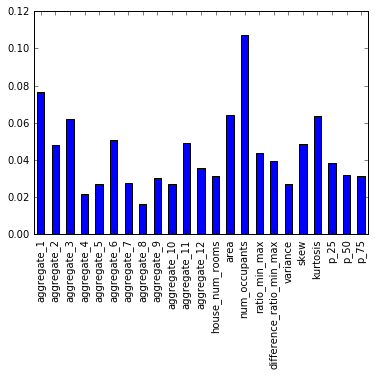

In [32]:
pd.Series(importances, index=all_features).plot(kind="bar")

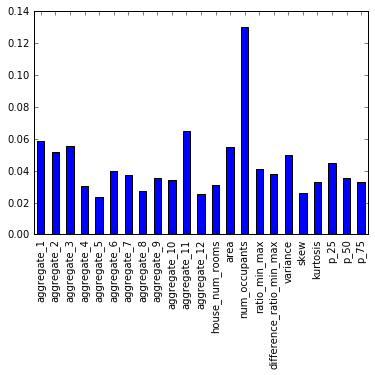

In [14]:
pd.Series(importances, index=all_features).plot(kind="bar")

In [104]:
(test_df['md_available']&test_df['full_agg_available']).sum()

7

In [28]:
test_df.describe().ix['count']

hvac_1                      25
hvac_2                      21
hvac_3                      21
hvac_4                      21
hvac_5                      21
hvac_6                      21
hvac_7                      19
hvac_8                      18
hvac_9                      17
hvac_10                     16
hvac_11                     15
hvac_12                     15
wm_1                         8
wm_2                         4
wm_3                         4
wm_4                         4
wm_5                         4
wm_6                         4
wm_7                         3
wm_8                         3
wm_9                         2
wm_10                        2
wm_11                        2
wm_12                        2
fridge_1                    23
fridge_2                    20
fridge_3                    20
fridge_4                    20
fridge_5                    20
fridge_6                    20
                            ..
dw_8                        18
dw_9    

In [52]:
month_compute=1
candidate_homes = train_normalised_df['%s_%d' %(appliance, month_compute)].dropna().index.values

In [63]:
len(candidate_homes)

24

In [54]:
candidate_homes

array([ 203,  203, 1450, 1450, 1524, 1524, 1731, 1731, 2354, 2354, 2606,
       2606, 3687, 3687, 3864, 3864, 3938, 3938, 4495, 4495, 4934, 4934,
       5938, 5938, 6377, 6377, 6547, 6547, 7062, 7062, 7114, 7114, 8061,
       8061, 8342, 8342, 8574, 8574, 8733, 8733, 9213, 9213, 9585, 9585,
       9612, 9612, 9775, 9775, 9836, 9836])

In [55]:
candidate_homes = np.array(np.setdiff1d(candidate_homes, test_home))

In [56]:
len(candidate_homes)

24

In [57]:
a,b= next(combinations(candidate_homes, 2))
a,b
com_features = find_com_features_train(train_df, a, b, f_all)

In [58]:
com_features

array(['aggregate_1', 'aggregate_10', 'aggregate_11', 'aggregate_12',
       'aggregate_2', 'aggregate_3', 'aggregate_4', 'aggregate_5',
       'aggregate_6', 'aggregate_7', 'aggregate_8', 'aggregate_9',
       'difference_ratio_min_max', 'kurtosis', 'p_25', 'p_50', 'p_75',
       'ratio_min_max', 'skew'], dtype=object)

In [61]:
%timeit is_common, d = find_distance_train_test(train_normalised_df, a, b, test_normalised_df, test_home, com_features, f_all)

100 loops, best of 3: 3.61 ms per loop


In [62]:
%timeit is_common, d = find_distance_train_test_quick(train_normalised_df, a, b, test_normalised_df, test_home, com_features, f_all)

100 loops, best of 3: 3.86 ms per loop


In [ ]:
for month_compute in range(1, 13):

    from collections import Counter, defaultdict
    num_features_all = {}
    ineq_dict = {}

    num_features_all[appliance] = {}
    ineq_dict[appliance] = {}

    #num_features_all[appliance][month_compute] = {}
    ineq_dict[appliance][month_compute] = {}

    candidate_homes = train_normalised_df['%s_%d' %(appliance, month_compute)].dropna().index.values



    #num_features_all[appliance][month_compute][test_home] = defaultdict(int)
    from collections import defaultdict
    import pandas as pd
    co = defaultdict(int)
    store_path = '../../../output/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                        test_region,
                                                                        transform,
                                                                        appliance,
                                                                        month_compute,
                                                                        test_home, K)
    print store_path
    if os.path.exists(store_path):
        print "already exists"
        continue


    if not np.isnan(test_normalised_df.ix[test_home]['%s_%d' %(appliance, month_compute)]):
        # We need to predict this value!
        # Find candidate set, train homes which have not null for this month
        # Now find features on pairs of homes in candidate homes
        for a,b in combinations(candidate_homes, 2):
            com_features = find_com_features_train(train_df, a, b, f_all)

            if len(com_features):
                # Consider a,b
                is_common, d = find_distance_train_test(train_normalised_df, a, b, test_normalised_df, test_home, com_features, f_all)
                if is_common:

                    # Common between train and test. Can add this pair to inequalities
                    ineq=d['order']
                    lt = ineq[0]
                    gt = ineq[1]
                    co[lt]-= 1
                    co[gt]+= 1
                    #num_features_all[appliance][month_compute][test_home][d['num_f']]+= 1

        """
        # Saving ineqs
        pickle.dump(ineqs, open('../data/model/inequalities/%s_%s_%s_%s_%d_%d.pkl' %(train_region,
                                                                        test_region,
                                                                        transform,
                                                                        appliance,
                                                                        month_compute,
                                                                        test_home),'w'))
        """
        co_ser = pd.Series(co)
        co_ser.sort()
        ranks = co_ser.index.values.tolist()
        if "percentage" in transform:
            mean_proportion = (train_df.ix[ranks[:K]]['%s_%d' %(appliance, month_compute)]/ train_df.ix[ranks[:K]]['aggregate_%d' %(month_compute)]).mean()

            pred = test_df.ix[test_home]['aggregate_%d' %month_compute]*mean_proportion

        else:
            pred = train_df.ix[ranks[:K]]['%s_%d' %(appliance, month_compute)].dropna().mean()
        gt = test_df.ix[test_home]['%s_%d' %(appliance, month_compute)]
        pickle.dump(pred, open(store_path,'w'))


    else:
        # No need to predict
        pass